In [1]:
from sklearn.linear_model import LinearRegression , SGDRegressor , LogisticRegression
from sklearn.model_selection import cross_validate,cross_val_score,learning_curve,ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')

In [3]:
train.nunique()

last contact date    1013
age                    78
job                    11
marital                 3
education               3
default                 2
balance              9535
housing                 2
loan                    2
contact                 2
duration             3146
campaign               63
pdays                 865
previous              276
poutcome                3
target                  2
dtype: int64

In [4]:
train.isna().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

In [5]:
train.shape

(39211, 16)

In [6]:
x = train.iloc[:,:-1]
y = train.iloc[:,-1]

In [7]:
def remove_null(df):
  for i in df.columns:
    if df[i].isna().sum() > (0.5*df.shape[0]):
      df.drop(columns=i,inplace=True)
  return df

In [8]:
x = remove_null(x)

In [9]:
x.columns

Index(['last contact date', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'duration', 'campaign',
       'pdays', 'previous'],
      dtype='object')

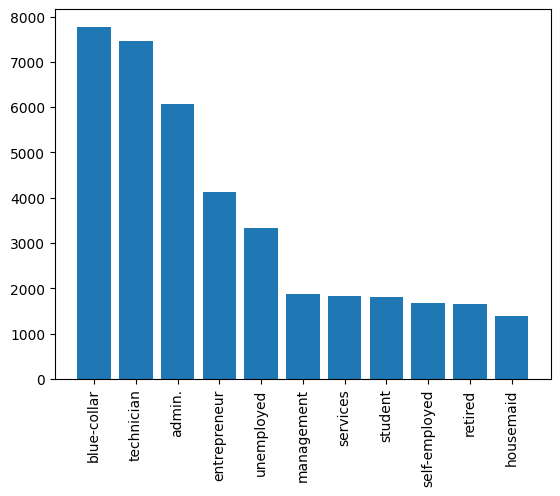

In [10]:
l = x['job'].value_counts()
val = [x for x in l] # Values for each type
l_1 = x['job'].unique()
val_1 = [x for x in l_1]
val_1.pop(-1)
# print(val_1)
plt.bar(val_1,val)
plt.xticks(rotation=90)
plt.show()

[19584, 11615, 6545]
['secondary', 'tertiary', 'primary']


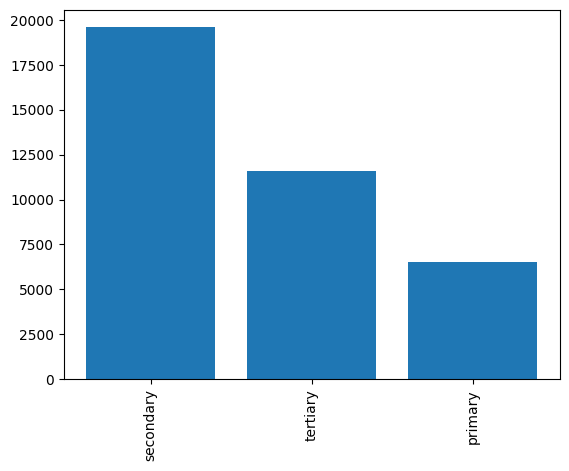

In [11]:
l = x['education'].value_counts()
val = [x for x in l] # Values for each type
l_1 = x['education'].unique()
val_1 = [x for x in l_1]
val_1.pop(-1)
print(val)
print(val_1)
# print(val_1)
plt.bar(val_1,val)
plt.xticks(rotation=90)
plt.show()

[25030, 3845]
['cellular', 'telephone']


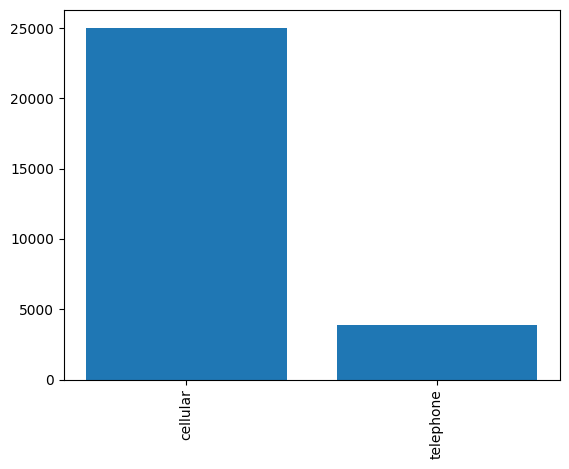

In [12]:
l = x['contact'].value_counts()
val = [x for x in l] # Values for each type
l_1 = x['contact'].unique()
val_1 = [x for x in l_1]
val_1.pop(-1)
print(val)
print(val_1)
# print(val_1)
plt.bar(val_1,val)
plt.xticks(rotation=90)
plt.show()

In [13]:
def replace_nulls(df):
  for i in df.columns:
    if df[i].isna().sum() > 0:
      val_count = df[i].value_counts(normalize=True)
      null_index = df[df[i].isna()].index
      replace_values = np.random.choice(val_count.index,size=len(null_index),p=val_count.values)
      df.loc[null_index,i] = replace_values
  return df

In [14]:
x = replace_nulls(x)

In [15]:
def convert_date(df):
  df['last contact date'] = pd.to_datetime(df['last contact date'],format='%Y-%m-%d')
  df['day'] = df['last contact date'].dt.day
  df['month'] = df['last contact date'].dt.month
  df['year'] = df['last contact date'].dt.year
  df.drop(columns='last contact date',inplace=True)
  return df

In [16]:
x = convert_date(x)

In [17]:
x.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,day,month,year
0,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,17,4,2009
1,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,11,10,2009
2,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,20,11,2010
3,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,1,9,2009
4,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,29,1,2008


In [18]:
education_order = [['primary', 'secondary', 'tertiary']]

In [19]:
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,LabelEncoder
one_hot = OneHotEncoder(handle_unknown='ignore',sparse_output=False,drop='first')
ordinal = OrdinalEncoder(categories=education_order)

In [20]:
col_to_label_encode = ['job','marital','default','housing','loan','contact']

In [21]:
x.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
duration     0
campaign     0
pdays        0
previous     0
day          0
month        0
year         0
dtype: int64

In [22]:
for i in col_to_label_encode:
  col_encoded = one_hot.fit_transform(x[[i]])
  col_encoded_df = pd.DataFrame(col_encoded,columns=one_hot.get_feature_names_out([i]))
  x = pd.concat([x,col_encoded_df],axis=1)
x=x.drop(columns=col_to_label_encode)
x['education'] = ordinal.fit_transform(x[['education']]) # [['education']] ensures that column is a 2D array.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [24]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
lin_reg_pipeline = Pipeline([("feature_scaling",StandardScaler()),
                             ('pca',PCA(n_components=15)),
                           ("lin_reg",LogisticRegression())])

lin_reg_pipeline.fit(x_train,y_train)
predict = lin_reg_pipeline.predict(x_test)
print(predict)

['no' 'no' 'no' ... 'no' 'no' 'no']


In [26]:

print(lin_reg_pipeline[-1].intercept_)
print(lin_reg_pipeline[-1].coef_)

[-1.96987026]
[[ 2.94582048e-01 -1.65358065e-01 -2.13273752e-01  2.07658416e-01
  -1.43528987e-01 -5.82149036e-03  1.02974272e-01  4.21055860e-02
  -3.71127120e-05 -3.73167417e-02  2.71970145e-02  6.31887851e-02
  -2.75209274e-02 -1.27439171e-01 -1.43674437e-01]]


In [27]:
y_test_new = y_test.to_numpy()

In [28]:
predict

array(['no', 'no', 'no', ..., 'no', 'no', 'no'], dtype=object)

In [29]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
print(accuracy_score(y_test,predict))
print(precision_score(y_test,predict,pos_label='yes'))
print(recall_score(y_test,predict,pos_label='yes'))
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predict)

0.8481448425347443
0.5108359133126935
0.13772954924874792


array([[6487,  158],
       [1033,  165]])

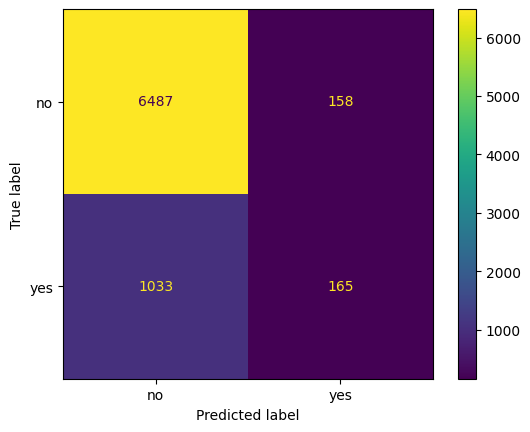

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, predict)

In [31]:
test_score = lin_reg_pipeline.score(x_test,y_test)
print(test_score)
train_score = lin_reg_pipeline.score(x_train,y_train) # Provides coeff of determination R^2 (explainability of variance)
print(train_score)

0.8481448425347443
0.8524929864830401


In [32]:
from sklearn.linear_model import SGDClassifier

sgd_teg_pipeline = Pipeline([("Feature_scaling",StandardScaler()),
                             ('pca',PCA(n_components=15)),
                             ("sgd",SGDClassifier(loss='hinge',penalty='l2',max_iter=5,random_state=42))])

In [33]:
sgd_teg_pipeline.fit(x_train,y_train)
predict = sgd_teg_pipeline.predict(x_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [34]:
print(predict)

['no' 'no' 'no' ... 'no' 'no' 'yes']


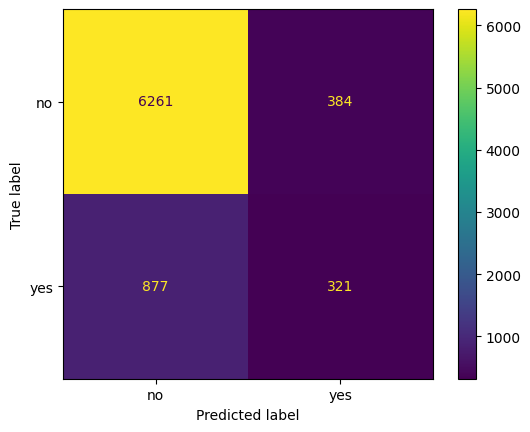

In [35]:

ConfusionMatrixDisplay.from_predictions(y_test, predict)

In [36]:
print(accuracy_score(y_test,predict))
print(precision_score(y_test,predict,pos_label='yes'))
print(recall_score(y_test,predict,pos_label='yes'))
confusion_matrix(y_test,predict)

0.839219686344511
0.4553191489361702
0.2679465776293823


array([[6261,  384],
       [ 877,  321]])

In [37]:
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
gnb.fit(x_train,y_train)

GaussianNB()

In [38]:
predict=gnb.predict(x_test)

In [39]:
print(accuracy_score(y_test,predict))
print(precision_score(y_test,predict,pos_label='yes'))
print(recall_score(y_test,predict,pos_label='yes'))
confusion_matrix(y_test,predict)

0.8450847889838072
0.48721804511278194
0.2704507512520868


array([[6304,  341],
       [ 874,  324]])

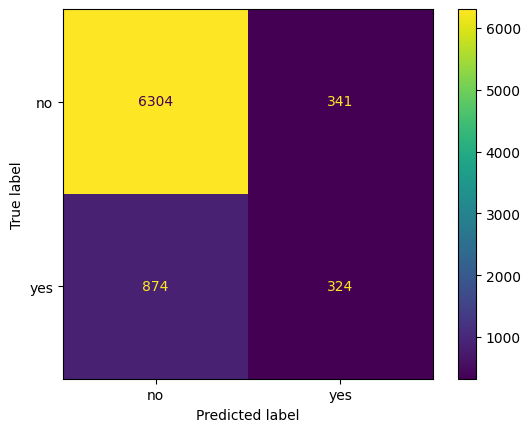

In [40]:
confusion_matrix(y_test,predict)
ConfusionMatrixDisplay.from_predictions(y_test,predict)

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors':[18,19,20]
}

In [42]:
from sklearn.neighbors import KNeighborsClassifier
grid_search = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,scoring='accuracy')
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [18, 19, 20]}, scoring='accuracy')

In [43]:
print(grid_search.best_params_)

{'n_neighbors': 19}


In [44]:
predict=grid_search.predict(x_test)

In [45]:
print(accuracy_score(y_test,predict))
print(precision_score(y_test,predict,pos_label='yes'))
print(recall_score(y_test,predict,pos_label='yes'))
confusion_matrix(y_test,predict)

0.8519699094734158
0.5265423242467718
0.3063439065108514


array([[6315,  330],
       [ 831,  367]])

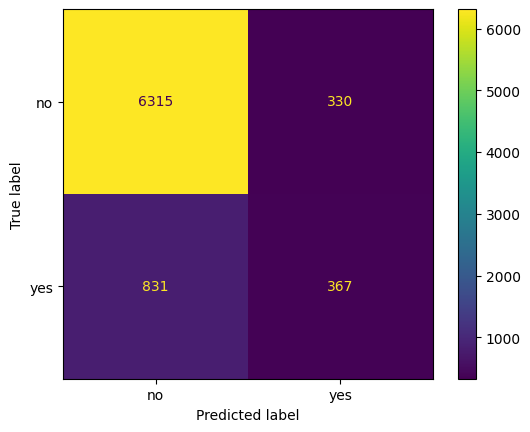

In [46]:
ConfusionMatrixDisplay.from_predictions(y_test,predict)

In [47]:
param_grid = {
    'C': [10],                   # Regularization parameter
    'kernel': ['rbf'],  # Kernel type
    'gamma': [10],             # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'coef0': [0.5],                # Independent term in kernel function for 'poly' and 'sigmoid'
}

In [48]:
from sklearn.svm import SVC
grid_search_svc = GridSearchCV(SVC(),param_grid=param_grid,cv=2,scoring='accuracy')
grid_search_svc.fit(x_train,y_train)

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [10], 'coef0': [0.5], 'gamma': [10],
                         'kernel': ['rbf']},
             scoring='accuracy')

In [49]:
print(grid_search_svc.best_params_)

{'C': 10, 'coef0': 0.5, 'gamma': 10, 'kernel': 'rbf'}


In [50]:
predict = grid_search_svc.predict(x_test)

In [51]:
print(accuracy_score(y_test,predict))
print(precision_score(y_test,predict,pos_label='yes'))
print(recall_score(y_test,predict,pos_label='yes'))
# for sigmoid...
# accuracy 0.7836287135024863
# precision 0.2865697177074423
# recall 0.27963272120200333
confusion_matrix(y_test,predict)

0.847252326915721
0.0
0.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[6645,    0],
       [1198,    0]])

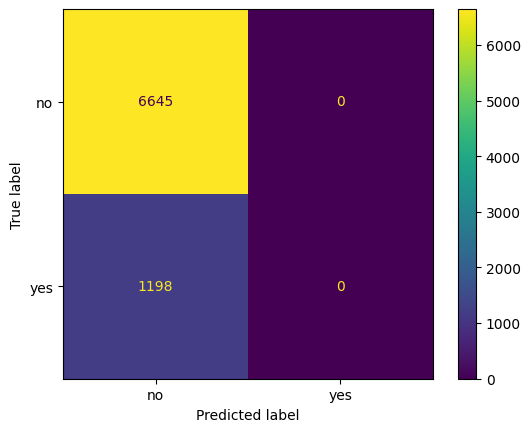

In [52]:
ConfusionMatrixDisplay.from_predictions(y_test,predict)

Using Gaussian Naive Bayes Algorithm finally

In [53]:
test = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

In [54]:
test.nunique()

last contact date     908
age                    77
job                    11
marital                 3
education               3
default                 2
balance              4384
housing                 2
loan                    2
contact                 2
duration             1664
campaign               63
pdays                 679
previous              261
poutcome                3
dtype: int64

In [55]:
test.isna().sum()

last contact date       0
age                     0
job                    59
marital                 0
education             390
default                 0
balance                 0
housing                 0
loan                    0
contact              2684
duration                0
campaign                0
pdays                   0
previous                0
poutcome             7508
dtype: int64

In [56]:
test = remove_null(test)
test = replace_nulls(test)
test = convert_date(test)

In [57]:
test.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
duration     0
campaign     0
pdays        0
previous     0
day          0
month        0
year         0
dtype: int64

In [58]:
for i in col_to_label_encode:
  col_encoded = one_hot.fit_transform(test[[i]])
  col_encoded_df = pd.DataFrame(col_encoded,columns=one_hot.get_feature_names_out([i]))
  test = pd.concat([test,col_encoded_df],axis=1)
test=test.drop(columns=col_to_label_encode)
test['education'] = ordinal.fit_transform(test[['education']]) # [['education']] ensures that column is a 2D array.

In [59]:
predict_for_test_dataset=gnb.predict(test)

In [60]:
predict_for_test_dataset

array(['no', 'no', 'no', ..., 'no', 'no', 'no'], dtype='<U3')

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)

In [63]:
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [64]:
y_pred = rf.predict(x_test)

In [65]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,pos_label='yes'))
print(recall_score(y_test,y_pred,pos_label='yes'))

0.8629351013642739
0.5749086479902558
0.39398998330550916


In [66]:
confusion_matrix(y_test,y_pred)

array([[6296,  349],
       [ 726,  472]])

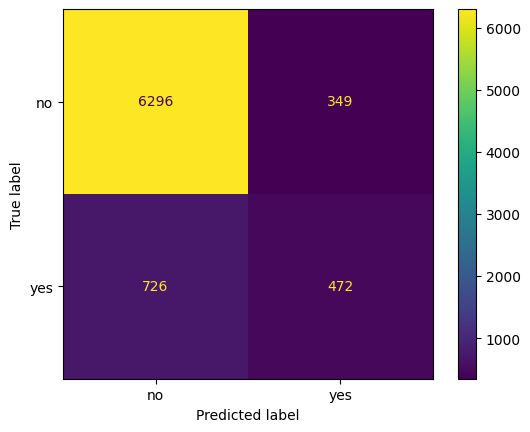

In [67]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [68]:
predict_for_test_dataset=rf.predict(test)

In [69]:
predict_for_test_dataset

array(['no', 'no', 'no', ..., 'no', 'no', 'no'], dtype=object)

In [70]:
predict_df = pd.DataFrame(predict_for_test_dataset,columns=['target'])

In [71]:
predict_df['target'].value_counts()

target
no     8981
yes    1019
Name: count, dtype: int64

In [72]:
predict_df.to_csv("Predictions.csv",index=True,index_label='id')

In [73]:
import xgboost as xgb

In [74]:
xgb_model = xgb.XGBClassifier(n_estimators=600, random_state=42, use_label_encoder=False) 
# use_label_encoder=False: Avoids warnings regarding label encoding.

In [75]:
y_train_for_xgboost = y_train.copy()
for i in range (y_train_for_xgboost.shape[0]):
    if y_train_for_xgboost.iloc[i] == 'yes':
        y_train_for_xgboost.iloc[i]=1
    else:
        y_train_for_xgboost.iloc[i]=0

In [76]:
y_test_for_xgboost = y_test.copy()
for i in range (y_test_for_xgboost.shape[0]):
    if y_test_for_xgboost.iloc[i] == 'yes':
        y_test_for_xgboost.iloc[i]=1
    else:
        y_test_for_xgboost.iloc[i]=0

In [77]:
y_train_for_xgboost

13800    0
32874    0
9072     0
26803    0
35504    0
        ..
6265     0
11284    0
38158    0
860      0
15795    0
Name: target, Length: 31368, dtype: object

In [78]:
xgb_model.fit(x_train, y_train_for_xgboost)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [79]:
predcit_xgb = xgb_model.predict(x_test)

In [80]:
predcit_xgb = pd.Series(predcit_xgb)

In [81]:
# for i in range (len(predcit_xgb)):
#     if predcit_xgb[i] == 1:
#         predcit_xgb[i]='yes'
#     elif predcit_xgb[i] == 0:
#         predcit_xgb[i]='no'

In [82]:
for i in range (predcit_xgb.shape[0]):
    if predcit_xgb.iloc[i] == 1:
        predcit_xgb.iloc[i]='yes'
    else:
        predcit_xgb.iloc[i]='no'

/tmp/ipykernel_17/3896072349.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'no' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  predcit_xgb.iloc[i]='no'


In [83]:
print(accuracy_score(y_test,predcit_xgb))
print(precision_score(y_test,predcit_xgb,pos_label='yes'))
print(recall_score(y_test,predcit_xgb,pos_label='yes'))

0.860512558969782
0.552
0.4607679465776294


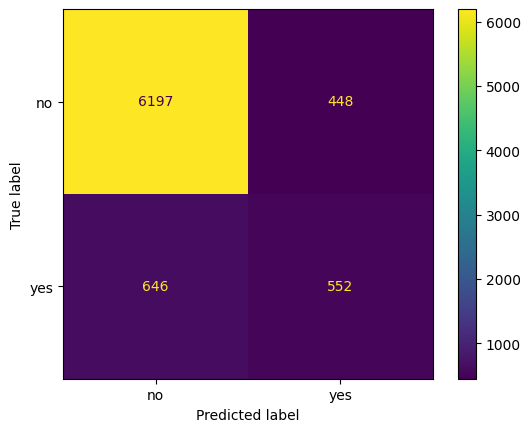

In [84]:
ConfusionMatrixDisplay.from_predictions(y_test,predcit_xgb)

In [85]:
predict_for_test_dataset=xgb_model.predict(test)

In [86]:
predict_for_test_dataset = pd.Series(predict_for_test_dataset)

In [87]:
for i in range (predict_for_test_dataset.shape[0]):
    if predict_for_test_dataset.iloc[i] == 1:
        predict_for_test_dataset.iloc[i]='yes'
    else:
        predict_for_test_dataset.iloc[i]='no'

/tmp/ipykernel_17/471904018.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'no' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  predict_for_test_dataset.iloc[i]='no'


In [88]:
predict_df = pd.DataFrame(predict_for_test_dataset,columns=['target'])

In [89]:
predict_df.to_csv("Predictions.csv",index=True,index_label='id')

In [90]:
predict_df.value_counts()

target
no        8777
yes       1223
Name: count, dtype: int64

finally XGBOOST gives the highest score.